In [12]:
pip install --upgrade yasa

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
yasa.__version__

'0.6.4'

In [3]:
pip install pingouin


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import mne
import yasa
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
from scipy.signal import hilbert
sns.set(style='ticks', font_scale=1.2)

In [14]:
# read-in the data
raw = mne.io.read_raw_brainvision(r"C:\Users\siann\Documents\SleepMem5a_S01_SpindleEEGTMS_20230705215233.vhdr", preload=True, verbose=None)

Extracting parameters from C:\Users\siann\Documents\SleepMem5a_S01_SpindleEEGTMS_20230705215233.vhdr...
Setting channel info structure...
Reading 0 ... 11659859  =      0.000 ...  2331.972 secs...


In [15]:
data = raw.get_data(['C4'], units="uV")
print(data.shape)

(1, 11659860)


In [16]:
# resample the raw data
raw.resample(100)
raw.ch_names

['Fp1',
 'Fp2',
 'F3',
 'F4',
 'C3',
 'C4',
 'P3',
 'P4',
 'O1',
 'O2',
 'F7',
 'F8',
 'T7',
 'T8',
 'P7',
 'P8',
 'AFz',
 'Fz',
 'Cz',
 'Pz',
 'FC1',
 'FC2',
 'CP1',
 'CP2',
 'FC5',
 'FC6',
 'CP5',
 'CP6',
 'FT9',
 'FT10',
 'TP9',
 'TP10',
 'F1',
 'F2',
 'C1',
 'C2',
 'P1',
 'P2',
 'AF3',
 'AF4',
 'FC3',
 'FC4',
 'CP3',
 'CP4',
 'PO3',
 'PO4',
 'F5',
 'F6',
 'C5',
 'C6',
 'P5',
 'P6',
 'AF7',
 'AF8',
 'FT7',
 'FT8',
 'TP7',
 'TP8',
 'PO7',
 'PO8',
 'Fpz',
 'CPz',
 'F9',
 'F10',
 'APBr',
 'FDIr',
 'ADMr',
 'HEOG',
 'VEOG',
 'EMG']

In [17]:
# select only data from C2
# idx_C2 = raw.ch_names.index('C2')
# selected_data = data[35, :]
# print(selected_data.shape)

In [32]:
# create a hyponogram

# initialize the sleep stageing 
sleep_stages = yasa.SleepStaging(raw, eeg_name = 'C4', eog_name="VEOG", emg_name="EMG") # use one EEG channel, one EOG and one chin channel
predicted = sleep_stages.predict() # predict the sleep stages
predicted_ss = yasa.hypno_str_to_int(predicted) # convert sleep stages in string form (N1, N2 etc.) to numbers (from 0 to 4)
yasa.plot_hypnogram(predicted_ss)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


05-Feb-24 10:57:24 | INFO | Using pre-trained classifier: C:\Users\siann\AppData\Roaming\Python\Python311\site-packages\yasa\classifiers\clf_eeg+eog+emg_lgb_0.5.0.joblib
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


AssertionError: `hypno` must be YASA Hypnogram.

In [37]:
# upsample the hypnogram to data
# because a lot of YASA functions require the sampling frequency of the hypnogram to be the same as for the PSG data
# so we need to upsample from 1/30 Hz to 100 Hz (with yasa.hypno_upsample_to_data)
predicted_ss_up = yasa.hypno_upsample_to_data(predicted_ss, sf_hypno = 1/30, data = raw, sf_data = 100)
print(len(predicted_ss_up))
print(len(raw))
# yasa.Hypnogram.plot_hypnogram(predicted_ss) # create hypnogram of predicted sleep stages

05-Feb-24 10:59:10 | WARNING | Hypnogram is SHORTER than data by 21.97 seconds. Padding hypnogram with last value to match data.size.


233197
233197


In [61]:
# using the method described in f.i. Staresina et al. (2015) or Helfrich et al. (2018)
# first detect slow-waves, and then calculate the PAC based on epochs that are centered around the negative peak of the slow-waves
sw = yasa.sw_detect(raw, sf=100, ch_names=["C4"], hypno=predicted_ss_up, include=(2, 3), coupling=True,
                    coupling_params=dict(freq_sp=(12, 16), time=3, p=None)) #time +-3, so using 6s window centered around negative peak of slow wave
slow_oscillations = sw.summary()
slow_oscillations.round(3)

# SigmaPeak column contains the timestamp (in seconds from the beginning of the recording) where the sigma-filtered (12 - 16 Hz, see freq_sp) amplitude is at its maximal (for each detected slow-wave)
# PhaseAtSigmaPeak column contains the phase (in radians) of the slow-wave filtered signal (0.3 - 1.5 Hz, see freq_sw) at SigmaPeak
#ndPAC columns contains the normalized mean vector length (indicates strength of PAC)

05-Feb-24 11:19:30 | ERROR | Wrong data amplitude for FT9 (trimmed STD = 1171.092). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:19:30 | ERROR | Wrong data amplitude for FT10 (trimmed STD = 2343.271). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:19:30 | ERROR | Wrong data amplitude for TP9 (trimmed STD = 1481.163). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:19:30 | ERROR | Wrong data amplitude for APBr (trimmed STD = 1662.957). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:19:30 | ERROR | Wrong data amplitude for ADMr (trimmed STD = 1552.598). Unit of data MUST be uV! Channel will be skipped.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Paral

,Start,NegPeak,MidCrossing,PosPeak,End,Duration,ValNegPeak,ValPosPeak,PTP,Slope,Frequency,SigmaPeak,PhaseAtSigmaPeak,ndPAC,Stage,Channel,IdxChannel
0,818.17,818.50,818.75,819.01,819.42,1.25,-74.448,61.908,136.356,545.423,0.800,817.65,1.183,0.043,2,Fp1,0
1,838.36,838.62,838.90,839.06,839.48,1.12,-92.479,29.415,121.895,435.338,0.893,839.30,0.775,0.181,2,Fp1,0
2,839.48,839.84,840.05,840.31,841.00,1.52,-62.628,86.118,148.746,708.312,0.658,839.30,0.775,0.365,2,Fp1,0
3,841.00,841.22,841.40,841.62,841.82,0.82,-43.628,54.480,98.108,545.042,1.220,839.30,0.775,0.283,2,Fp1,0
4,843.55,843.72,843.89,844.09,844.28,0.73,-45.739,50.563,96.302,566.484,1.370,844.96,0.362,0.209,2,Fp1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22187,2109.61,2109.84,2110.07,2110.35,2110.71,1.10,-63.402,61.974,125.376,545.113,0.909,2108.60,-0.262,0.248,3,VEOG,68
22188,2110.71,2111.12,2111.48,2111.70,2111.88,1.17,-53.580,39.486,93.065,258.515,0.855,2108.60,-0.262,0.200,3,VEOG,68
22189,2122.45,2123.33,2123.68,2123.78,2123.92,1.47,-134.659,13.997,148.657,424.733,0.680,2120.78,-1.728,0.220,3,VEOG,68
22190,2125.21,2125.55,2126.40,2126.90,2127.22,2.01,-92.892,52.804,145.696,171.407,0.498,2124.79,2.133,0.140,3,VEOG,68


In [ ]:
# Using the Pingouin package, we can then easily extract and visualize the direction (phase) and strength of coupling across all channels:
pg.plot_circmean(events['PhaseAtSigmaPeak'])
print('Circular mean: %.3f rad' % pg.circ_mean(events['PhaseAtSigmaPeak']))
print('Vector length: %.3f' % pg.circ_r(events['PhaseAtSigmaPeak']))
# direction of the vector represents phase of the SO and length of the vector represents sample variance of preferred phase and therefore does not represent coupling strength). 

In [ ]:
events['ndPAC'].hist();

In [27]:
# do simple cross-correlation between events of identified spindle events (troughs and peaks) and the SO-upstates (like what they did in Mölle et al., 2011)
# using 6-sec windows with 3-sec offsets and a bin size of 50 msec.
# The counts in every bin were divided by the number of spindles or SOs used as reference, and then divided by the bin width to give event rate per second (Hz).
# they do correlation between spindle occurence rate and peak of SO
# here: (easier to do)
import scipy
scipy.signal.correlate(events.SigmaPeak, events.PosPeak, mode = 'full')

array([1.66550323e+06, 3.44310174e+06, 5.21655290e+06, 7.00297604e+06,
       8.85540195e+06, 1.07055835e+07, 1.26730649e+07, 1.47121061e+07,
       1.68334867e+07, 1.89918610e+07, 2.11484405e+07, 2.33008756e+07,
       2.54691468e+07, 2.77097355e+07, 2.99570316e+07, 3.22013674e+07,
       3.44428763e+07, 3.66804416e+07, 3.89165209e+07, 4.11509096e+07,
       4.33902362e+07, 4.57908003e+07, 4.81974537e+07, 5.06699898e+07,
       5.31502252e+07, 5.56261865e+07, 5.81177397e+07, 6.06919359e+07,
       6.32689135e+07, 6.58427625e+07, 6.84109128e+07, 7.10262016e+07,
       7.36305638e+07, 7.62323385e+07, 7.88617292e+07, 8.14808316e+07,
       8.41386226e+07, 8.67922666e+07, 8.94383123e+07, 9.21258050e+07,
       9.48104628e+07, 9.75040503e+07, 1.00177518e+08, 1.02847200e+08,
       1.05514867e+08, 1.08189268e+08, 1.10867621e+08, 1.13553419e+08,
       1.16235658e+08, 1.18929001e+08, 1.21618945e+08, 1.24305979e+08,
       1.26993482e+08, 1.29726266e+08, 1.32497263e+08, 1.35264270e+08,
      

In [50]:
# detect spindles 
spindles = yasa.spindles_detect(data=raw, sf=100,ch_names=['C4'], hypno=predicted_ss_up, include=(2, 3))
sp = spindles.summary()
print(sp)

05-Feb-24 11:12:59 | ERROR | Wrong data amplitude for FT9 (trimmed STD = 1171.092). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:12:59 | ERROR | Wrong data amplitude for FT10 (trimmed STD = 2343.271). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:12:59 | ERROR | Wrong data amplitude for TP9 (trimmed STD = 1481.163). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:12:59 | ERROR | Wrong data amplitude for APBr (trimmed STD = 1662.957). Unit of data MUST be uV! Channel will be skipped.
05-Feb-24 11:12:59 | ERROR | Wrong data amplitude for ADMr (trimmed STD = 1552.598). Unit of data MUST be uV! Channel will be skipped.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Paral

     Start    Peak     End  Duration   Amplitude        RMS  AbsPower  \
0   897.77  898.34  898.59      0.82   57.811968  12.383002  1.942022   
1   801.32  801.51  801.96      0.64   64.937630  14.619045  2.213462   
2   855.33  855.64  855.84      0.51   48.353885  12.707822  2.221502   
3   897.79  898.33  898.57      0.78   65.159797  13.858069  1.850546   
4   988.38  988.73  988.90      0.52   85.269341  22.954521  2.751532   
..     ...     ...     ...       ...         ...        ...       ...   
81  988.33  988.89  989.18      0.85  112.018821  28.871287  2.758915   
82  897.78  898.33  898.57      0.79   64.809001  13.380424  1.915024   
83  988.23  988.89  989.10      0.87   99.447378  19.000756  2.360760   
84  801.26  801.51  802.16      0.90   98.041691  19.411490  2.624097   
85  995.61  995.97  996.25      0.64   22.199340   5.146821  1.246849   

    RelPower  Frequency  Oscillations  Symmetry  Stage Channel  IdxChannel  
0   0.316214  14.069206          11.0  0.68674

In [58]:
mask = sp['Channel'].isin(['C4', 'C3'])
spindles_in_c3_c4 = sp[mask]

print(spindles_in_c3_c4)

     Start    Peak     End  Duration  Amplitude        RMS  AbsPower  \
7   898.29  898.63  898.87      0.58  48.562045  11.891348  2.141890   
8   961.78  962.00  962.36      0.58  31.273776   8.193807  1.929581   
9   988.30  988.90  989.20      0.90  62.430517  13.669451  2.206553   
10  988.26  988.89  989.18      0.92  69.455863  13.921031  2.135984   

    RelPower  Frequency  Oscillations  Symmetry  Stage Channel  IdxChannel  
7   0.243817  13.965818           8.0  0.576271      2      C3           4  
8   0.284923  12.399454           7.0  0.372881      2      C3           4  
9   0.335541  12.895044          11.0  0.659341      2      C3           4  
10  0.419550  13.128303          12.0  0.677419      2      C4           5  


In [65]:
mask = slow_oscillations['Channel'].isin(['C4', 'C3'])
sos_in_c3_c4 = slow_oscillations[mask]

print(sos_in_c3_c4)

        Start  NegPeak  MidCrossing  PosPeak      End  Duration  ValNegPeak  \
1469   838.14   838.34       838.50   838.70   838.88      0.74  -44.813683   
1470   838.88   839.11       839.38   839.55   840.12      1.24  -84.621549   
1471   840.12   840.42       840.72   841.18   841.48      1.36  -65.062238   
1472   880.33   880.57       880.76   881.01   881.24      0.91  -43.746051   
1473   933.74   934.05       934.34   934.60   934.92      1.18  -87.482122   
...       ...      ...          ...      ...      ...       ...         ...   
1989  2107.28  2107.59      2107.82  2108.17  2108.47      1.19  -42.452625   
1990  2110.05  2110.40      2110.72  2111.11  2111.47      1.42  -58.518061   
1991  2111.47  2111.73      2111.95  2112.17  2112.44      0.97  -71.963793   
1992  2115.86  2116.41      2116.72  2116.90  2117.11      1.25  -80.028135   
1993  2123.49  2123.77      2124.54  2124.80  2125.50      2.01  -55.394509   

      ValPosPeak         PTP       Slope  Frequency

C:\Users\siann\AppData\Roaming\Python\Python311\site-packages\yasa\detection.py:477: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df_sync, x="Time", y="Amplitude", hue=hue, ax=ax, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


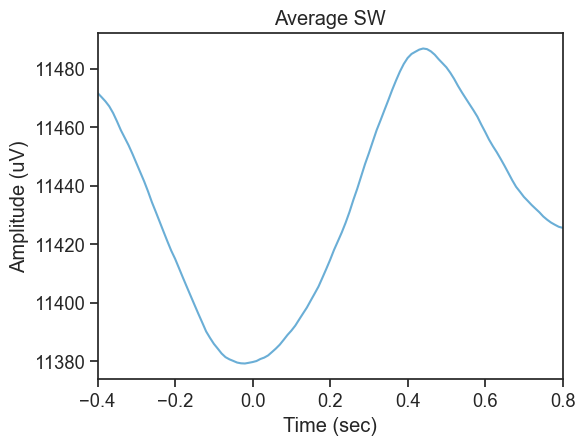

In [71]:
mask_2 = slow_oscillations['Channel'].isin(['C4'])
sw.plot_average(ci=None, legend=False, palette="Blues", mask = mask_2);

In [81]:
# save detected spindles and SOs as csv files to export to matlab
spindles_in_c3_c4.to_csv('C:/Users/siann/Downloads/df_spindles.csv', index = False)
sos_in_c3_c4.to_csv('C:/Users/siann/Downloads/df_sos.csv', index = False)